In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas_ta as ta

from technical_analysis.indicators import Indicators
import technical_analysis.backtest_kz as bt
from data_pipelines.data_manipulation import DataManipulation
from strategy_kz.strategy_var import StrategyVar

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [10]:
interval = 'hour'
df_m = pd.read_csv(f'../data/tweets_data/mansuryavas/mansuryavas_{interval}.csv', index_col=[0])
df_e = pd.read_csv(f'../data/tweets_data/ekremimamoglu/ekremimamoglu_{interval}.csv', index_col=[0])
df_k = pd.read_csv(f'../data/tweets_data/kemalkilicdaroglu/kemalkilicdaroglu_{interval}.csv', index_col=[0])
df_r = pd.read_csv(f'../data/tweets_data/receptayyiperdogan/receptayyiperdogan_{interval}.csv', index_col=[0])

<AxesSubplot: xlabel='Datetime'>

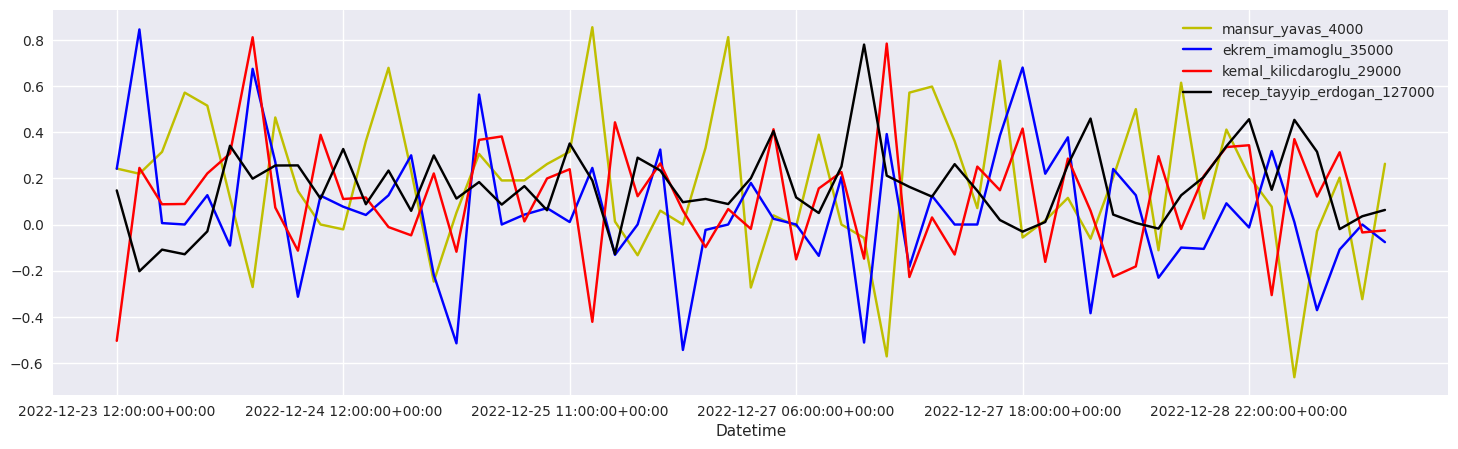

In [11]:
df_com = df_m.copy()
df_com.columns = [f'mansur_yavas_4000']
df_com[f'ekrem_imamoglu_35000'] = df_e['compound_total']
df_com[f'kemal_kilicdaroglu_29000'] = df_k['compound_total']
df_com[f'recep_tayyip_erdogan_127000'] = df_r['compound_total']
df_com.dropna(inplace=True)
df_com.plot(figsize=(18,5), color=['y', 'b', 'r', 'k'])

<AxesSubplot: xlabel='Datetime'>

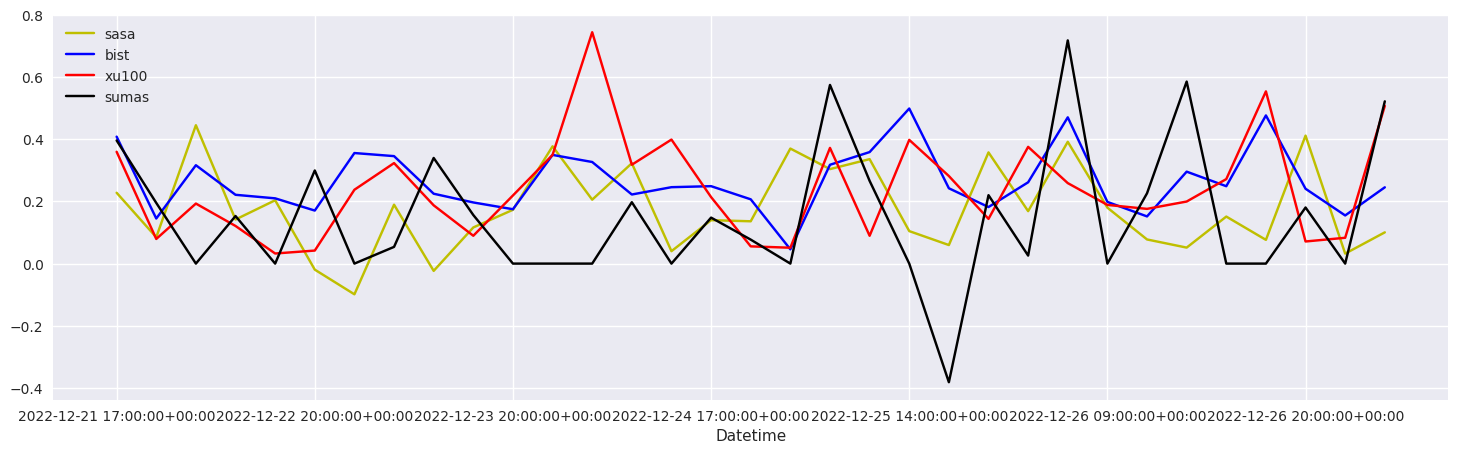

In [12]:
interval = 'hour'
df_m = pd.read_csv(f'../data/tweets_data/sasa/sasa_{interval}.csv', index_col=[0])
df_e = pd.read_csv(f'../data/tweets_data/bist/bist_{interval}.csv', index_col=[0])
df_k = pd.read_csv(f'../data/tweets_data/xu100/xu100_{interval}.csv', index_col=[0])
df_r = pd.read_csv(f'../data/tweets_data/sumas/sumas_{interval}.csv', index_col=[0])

df_com = df_m.copy()
df_com.columns = [f'sasa']
df_com[f'bist'] = df_e['compound_total']
df_com[f'xu100'] = df_k['compound_total']
df_com[f'sumas'] = df_r['compound_total']
df_com.dropna(inplace=True)
df_com.plot(figsize=(18,5), color=['y', 'b', 'r', 'k'])

In [3]:
SYMBOL = ''
scale = 1
range_list = [5, 9,10,12, 15, 20, 26, 50, 200]
range_list = [i*scale for i in range_list]
period = 'max'
interval = '1d'
start_date = ''
end_data = ''
source = 'yahoo'

In [5]:
res_dict = []
st = StrategyVar('emacross')
for i in ['TCELL.IS', 'BIMAS.IS', 'AKSA.IS']:   #, 'CCOLA.IS', 'CIMSA.IS', 'EREGL.IS', 'PETKM.IS'
    symbol = i
    data = DataManipulation(symbol, source, range_list, period=period, interval=interval, scale=scale, prefix_path='..', saved_to_csv=False)
    df_result = st.create_ema_labels(data.df.copy())
    res = st.find_best_cross_strategy(symbol, df_result)
    res_dict.append(res)
    

[*********************100%***********************]  1 of 1 completed
Get TCELL.IS data from yahoo period: max and interval: 1d
Start TA-LIB module


100%|██████████| 9/9 [00:00<00:00, 652.96it/s]


Calculated SMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated BOLLINGERBAND for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 649.78it/s]


Calculated DEMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 682.94it/s]


Calculated EMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 460.46it/s]


Calculated KAMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 651.17it/s]


Calculated T3 for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 647.70it/s]


Calculated TEMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 647.66it/s]


Calculated TRIMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 93.72it/s]


Calculated WMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated ADX for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated DMN for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated DMP for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 14.78it/s]


Calculated CMO for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated MACD
Calculated CCI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 12.51it/s]


Calculated RSI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated WILLR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated MFI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated OBV
Calculated AD
Calculated ATRR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated NATR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 14.04it/s]


Calculated ROC for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
created indicators columns with TA-LIB
Created Indicator object and indicators columns
Created Feature label for next day and dropn NaN values
{'TCELL.IS': ('ema5_cross_ema10', 0.02)}
{'TCELL.IS': ('ema5_cross_ema10', 0.037)}
{'TCELL.IS': ('ema5_cross_ema10', 0.129)}
[*********************100%***********************]  1 of 1 completed
Get BIMAS.IS data from yahoo period: max and interval: 1d
Start TA-LIB module


100%|██████████| 9/9 [00:00<00:00, 613.22it/s]


Calculated SMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated BOLLINGERBAND for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 631.30it/s]


Calculated DEMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 646.05it/s]


Calculated EMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 572.39it/s]


Calculated KAMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 582.57it/s]


Calculated T3 for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 387.11it/s]


Calculated TEMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 466.56it/s]


Calculated TRIMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 95.25it/s]


Calculated WMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated ADX for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated DMN for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated DMP for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 12.65it/s]


Calculated CMO for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated MACD
Calculated CCI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 13.72it/s]


Calculated RSI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated WILLR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated MFI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated OBV
Calculated AD
Calculated ATRR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated NATR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 14.48it/s]


Calculated ROC for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
created indicators columns with TA-LIB
Created Indicator object and indicators columns
Created Feature label for next day and dropn NaN values
{'BIMAS.IS': ('ema5_cross_ema10', 0.051)}
{'BIMAS.IS': ('ema5_cross_ema20', 0.055)}
[*********************100%***********************]  1 of 1 completed
Get AKSA.IS data from yahoo period: max and interval: 1d
Start TA-LIB module


100%|██████████| 9/9 [00:00<00:00, 663.15it/s]


Calculated SMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated BOLLINGERBAND for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 529.49it/s]


Calculated DEMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 521.40it/s]


Calculated EMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 457.98it/s]


Calculated KAMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 481.44it/s]


Calculated T3 for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 442.86it/s]


Calculated TEMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 406.52it/s]


Calculated TRIMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 93.92it/s]


Calculated WMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated ADX for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated DMN for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated DMP for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 13.68it/s]


Calculated CMO for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated MACD
Calculated CCI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 13.32it/s]


Calculated RSI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated WILLR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated MFI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated OBV
Calculated AD
Calculated ATRR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated NATR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 13.51it/s]


Calculated ROC for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
created indicators columns with TA-LIB
Created Indicator object and indicators columns
Created Feature label for next day and dropn NaN values
{'AKSA.IS': ('ema5_cross_ema10', 0.02)}
{'AKSA.IS': ('ema5_cross_ema10', 0.025)}
{'AKSA.IS': ('ema5_cross_ema10', 0.153)}
{'AKSA.IS': ('ema9_cross_ema26', 0.188)}


In [18]:
res_dict

[{'TCELL.IS': ('ema5_cross_ema10', 0.129)},
 {'BIMAS.IS': ('ema5_cross_ema20', 0.055)},
 {'AKSA.IS': ('ema9_cross_ema26', 0.188)}]

[*********************100%***********************]  1 of 1 completed
Get PETKM.IS data from yahoo period: max and interval: 1d
Start TA-LIB module


100%|██████████| 9/9 [00:00<00:00, 700.20it/s]


Calculated SMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated BOLLINGERBAND for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 452.51it/s]


Calculated DEMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 539.92it/s]


Calculated EMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 598.02it/s]


Calculated KAMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 519.45it/s]


Calculated T3 for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 495.81it/s]


Calculated TEMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 412.40it/s]


Calculated TRIMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 86.68it/s]


Calculated WMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated ADX for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated DMN for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated DMP for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 13.87it/s]


Calculated CMO for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated MACD
Calculated CCI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 13.81it/s]


Calculated RSI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated WILLR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated MFI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated OBV
Calculated AD
Calculated ATRR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated NATR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 13.59it/s]


Calculated ROC for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
created indicators columns with TA-LIB
Created Indicator object and indicators columns
Created Feature label for next day and dropn NaN values
[*********************100%***********************]  1 of 1 completed
Get KRDMD.IS data from yahoo period: max and interval: 1d
Start TA-LIB module


100%|██████████| 9/9 [00:00<00:00, 541.56it/s]


Calculated SMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated BOLLINGERBAND for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 633.76it/s]


Calculated DEMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 647.18it/s]


Calculated EMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 556.35it/s]


Calculated KAMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 624.28it/s]


Calculated T3 for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 638.06it/s]


Calculated TEMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 681.53it/s]


Calculated TRIMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 98.17it/s]


Calculated WMA for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated ADX for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated DMN for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated DMP for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 13.70it/s]


Calculated CMO for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated MACD
Calculated CCI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 12.25it/s]


Calculated RSI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated WILLR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated MFI for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated OBV
Calculated AD
Calculated ATRR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
Calculated NATR for range [5, 9, 10, 12, 15, 20, 26, 50, 200]


100%|██████████| 9/9 [00:00<00:00, 13.06it/s]


Calculated ROC for range [5, 9, 10, 12, 15, 20, 26, 50, 200]
created indicators columns with TA-LIB
Created Indicator object and indicators columns
Created Feature label for next day and dropn NaN values


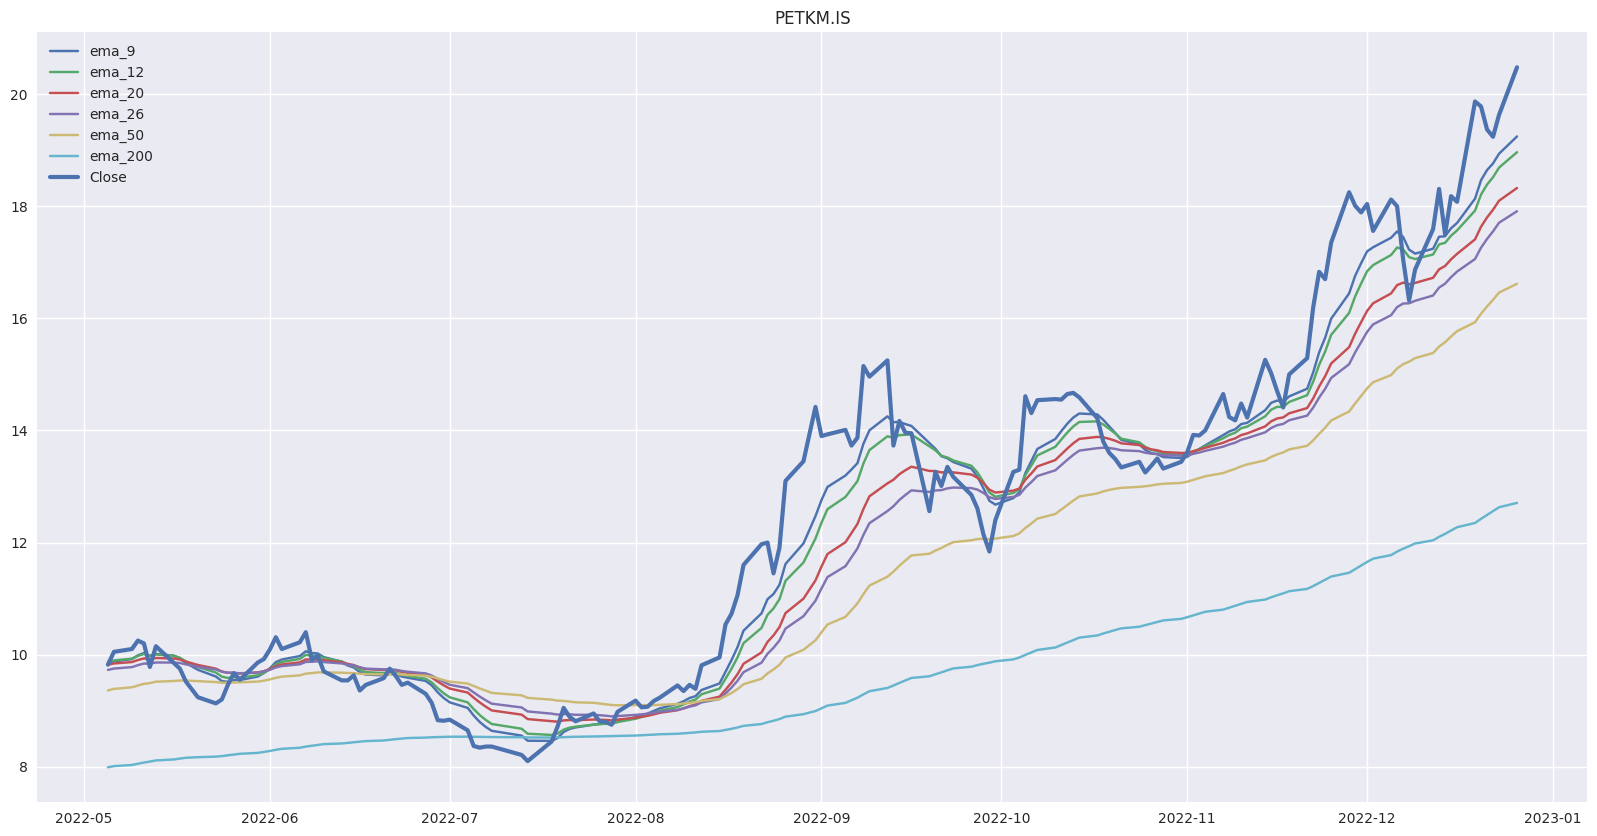

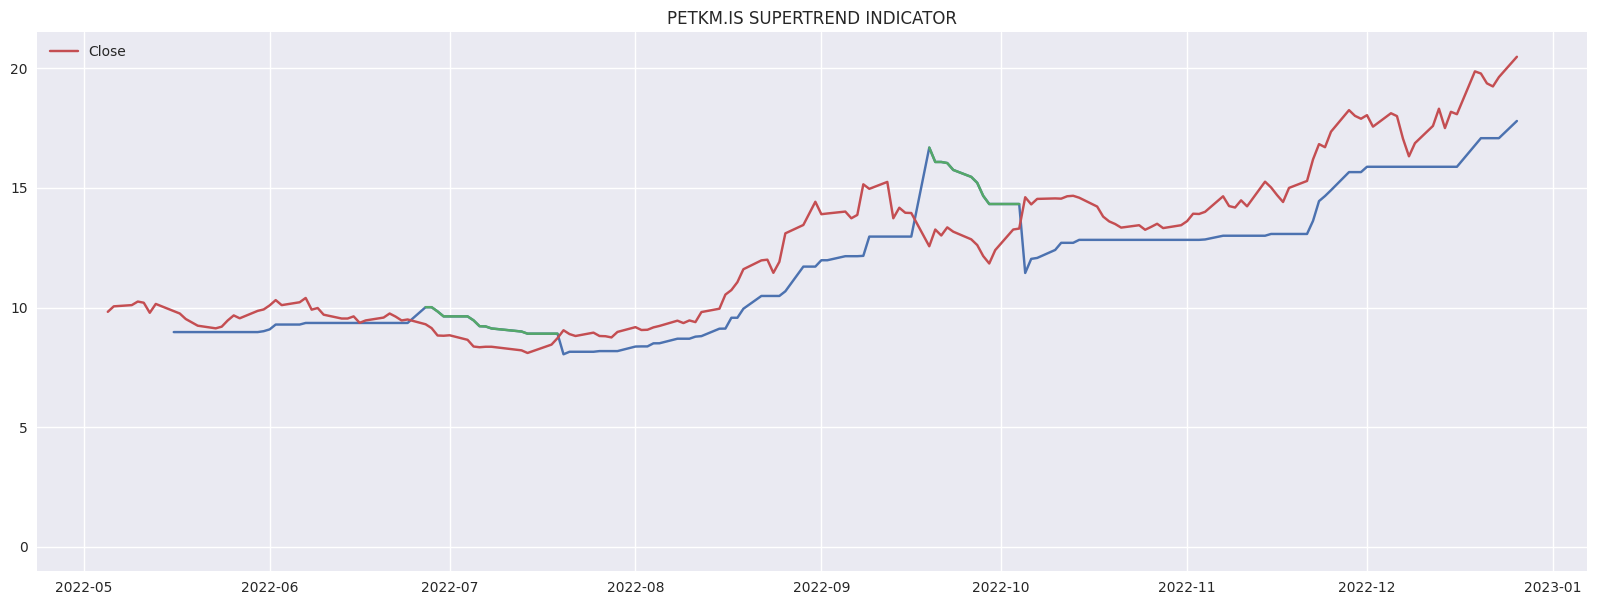

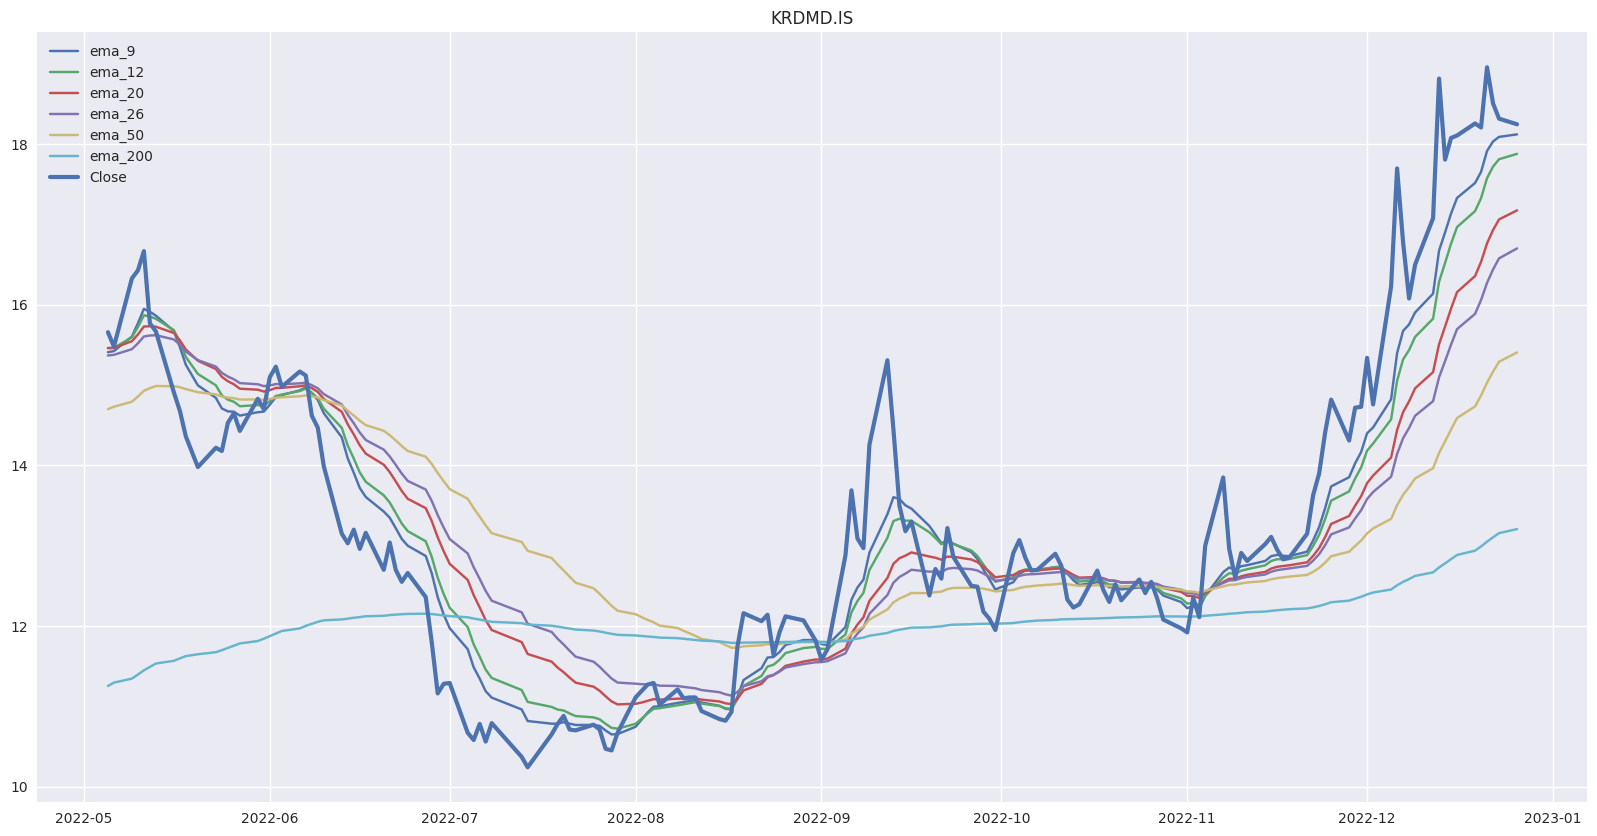

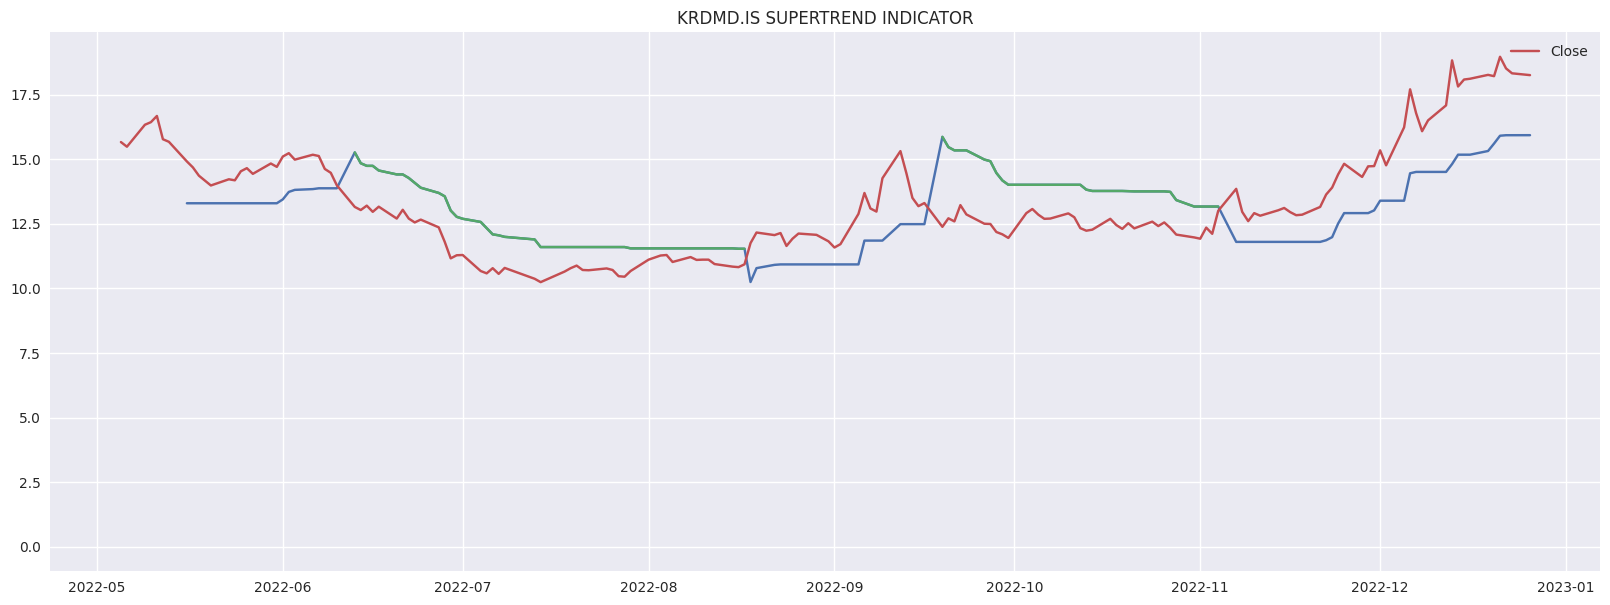

In [22]:
symbols = pd.read_csv('../data/symbol_data/bist100.csv', index_col=[0])

for i in range(1, 3):
    rnd = random.randint(1, len(symbols))
    SYMBOL = f"{symbols.loc[rnd, 'Code']}.IS"
    data = DataManipulation(SYMBOL, source, range_list, period=period, interval=interval, scale=scale, prefix_path='..', saved_to_csv=False)

    df_temp = data.df.loc['2022-05':,:].copy()
    
    #SUPERTREND indicator
    sti = ta.supertrend(df_temp['high'], df_temp['low'], df_temp['close'], length=7, multiplier=3)
    sti.drop(columns=['SUPERTd_7_3.0', 'SUPERTl_7_3.0'], inplace=True)
    sti.columns = ['supertrend_support', 'supertrend_resistance']

    # PLOT THE EMA'S
    fig, ax1 = plt.subplots(1,1, figsize=(20,10))
    ax1.plot(df_temp.ema_9, label='ema_9')
    ax1.plot(df_temp.ema_12, label='ema_12')
    ax1.plot(df_temp.ema_20, label='ema_20')
    ax1.plot(df_temp.ema_26, label='ema_26')
    ax1.plot(df_temp.ema_50, label='ema_50')
    ax1.plot(df_temp.ema_200, label='ema_200')
    ax1.plot(df_temp.close, label='Close', linewidth=3)
    ax1.set_title(f'{SYMBOL}')
    ax1.legend()
    fig.savefig(f'./plots/ema_strategy_{SYMBOL}.png')

    # PLOT THE SUPERTREND
    fig, ax = plt.subplots(figsize=(20,7))
    ax.plot(sti)
    ax.plot(df_temp.close, label='Close')
    ax.set_title(f'{SYMBOL} SUPERTREND INDICATOR')
    ax.legend()
    fig.savefig(f'./plots/supertrend_{SYMBOL}.png')
